In [1]:
from simbad_download import resolve_name
import pandas as pd

from astropy.coordinates import ICRS, SkyCoord
import astropy.units as u

import numpy as np

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
KAPPA = 4.74047

In [1063]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name('NGC 188')

In [4]:
sources = pd.read_csv('NGC 188.csv')

In [5]:
len(sources)

49629

In [1003]:
sources.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,labels
0,1636148068921376768,Gaia DR3 574509467058245248,574509467058245248,1493410390,2016.0,35.762865,0.029851,85.164665,0.029967,0.545239,...,0.2003,0.2590,0.1852,0.1610,0.2085,0.0981,0.0852,0.1104,MARCS,-1
1,1636148068921376768,Gaia DR3 574509467058245632,574509467058245632,671685054,2016.0,35.689345,0.127046,85.157645,0.129013,0.276671,...,0.3600,0.4324,0.2899,0.2639,0.3176,0.1549,0.1415,0.1696,MARCS,-1
2,1636148068921376768,Gaia DR3 574509497122165760,574509497122165760,998946401,2016.0,35.790532,0.125888,85.170221,0.133328,0.700458,...,0.0049,0.0432,0.0132,0.0035,0.0310,0.0071,0.0019,0.0167,PHOENIX,-1
3,1636148068921376768,Gaia DR3 574509634560358272,574509634560358272,1157546964,2016.0,35.942416,0.145537,85.191924,0.142934,0.419366,...,0.0008,0.0093,0.0024,0.0006,0.0068,0.0013,0.0003,0.0037,PHOENIX,-1
4,1636148068921376768,Gaia DR3 574512555138118272,574512555138118272,1114709481,2016.0,35.841332,0.352966,85.192230,0.388702,0.268799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [1004]:
sky_coords = SkyCoord(ra=sources['ra'].values,
                      dec=sources['dec'].values,
                      unit=(u.deg, u.deg),
                      frame=ICRS)

sources.ra = sky_coords.ra.wrap_at(180 * u.deg).value

In [1005]:
coordinates = SkyCoord(ra=sources.ra.values*u.deg, dec=sources.dec.values*u.deg, 
                       distance=(1/sources.parallax.values)*u.kpc, radial_velocity=radvel*u.km/u.s,
                       pm_ra_cosdec=sources.pmra.values*u.mas/u.yr, pm_dec=sources.pmdec.values*u.mas/u.yr,
                       frame=ICRS)

The perpendicular and parallel motions $\mu_\parallel$ and $\mu_\perp$ are defined as:

$\begin{bmatrix}
\mu_\parallel \\
\mu_\perp
\end{bmatrix} = 
\begin{bmatrix}
\rm sin\theta & \rm cos\theta \\
-\rm cos\theta & \rm sin\theta \\
\end{bmatrix}
\begin{bmatrix}
\mu_{\alpha*} \\
\mu_\delta
\end{bmatrix}$

where $\theta$ is defined as:

$\rm tan\theta = \frac{\rm sin(\alpha_{\rm cp}-\alpha)}{\rm cos\delta\rm tan\delta_{\rm cp}-\rm sin\delta\rm cos(\alpha_{\rm cp}-\alpha)}$

The coordinates of the convergent point $(\alpha_{\rm cp}, \delta_{\rm cp})$ can be set to the cluster center.

In [1006]:
galactic_cartesian = coordinates.galactic.cartesian

In [1048]:
def cp_proper_motions(ra: np.float32, 
                      dec: np.float32,
                      pmra: np.float32,
                      pmdec: np.float32,
                      cp_ra: np.float32,
                      cp_dec: np.float32) -> np.matrix:
    tan_theta = (np.sin(np.deg2rad(cp_ra-ra))/
                 ((np.cos(np.deg2rad(dec))*np.tan(np.deg2rad(cp_dec)))-
                  (np.sin(np.deg2rad(dec))*np.cos(np.deg2rad(cp_ra-ra)))))
    
    theta = np.arctan(tan_theta)
    
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    return np.squeeze(np.asarray(np.matmul(
                np.matrix([[sin_theta, cos_theta],
                           [-cos_theta, sin_theta]]),
                np.matrix([[pmra], [pmdec]]))))

In [1059]:
np.matmul(np.matrix([[1, 2], [-3, 4]]), np.matrix([[10], [2]]))

matrix([[ 14],
        [-22]])

In [1060]:
matrices = np.vectorize(cp_proper_motions, excluded=['cp_ra', 'cp_dec'], otypes=[np.ndarray])

In [1064]:
cp_proper_motions(cp_ra+.0001, cp_dec+.0001, cp_pmra, cp_pmdec, cp_ra, cp_dec)

array([-1.1439948 ,  2.22177043])

In [1065]:
cp_pmra, cp_pmdec

(-2.3087, -0.9565)

In [1057]:
proper_motions = np.stack(matrices(sources.ra.values, sources.dec.values,
         sources.pmra.values, sources.pmdec.values,
         ra, dec))

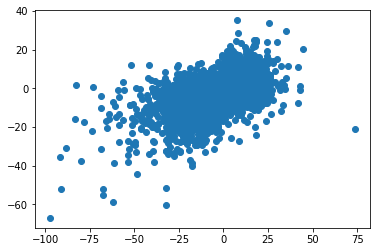

In [1058]:
plt.scatter(proper_motions[:, 0]-sources.pmra.values, proper_motions[:, 1])

In [1012]:
cluster_values = pd.DataFrame(data=np.array([
    galactic_cartesian.x.value,
    galactic_cartesian.y.value,
    galactic_cartesian.z.value,
    proper_motions[:, 0]-sources.pmra.values,
    proper_motions[:, 1]
]).T, columns=['x', 'y', 'z', 'u_par', 'u_per'])

In [1013]:
from scipy import stats

In [1014]:
cluster_values.describe()

,x,y,z,u_par,u_per
count,49629.000000,49629.000000,49629.000000,49629.000000,49629.000000
mean,-1.137160,1.760307,0.857483,0.754517,0.083205
std,0.349149,0.537751,0.263130,6.172255,4.007611
min,-2.113696,1.009403,0.466702,-97.164538,-66.958579
25%,-1.370051,1.317717,0.642390,-0.743712,-1.596037
50%,-1.055439,1.634168,0.796318,0.827919,0.398689
75%,-0.851287,2.120390,1.032094,3.399118,2.221578
max,-0.629624,3.182711,1.640484,73.712959,35.298278


In [1015]:
#cluster_values_q = cluster_values[(np.abs(stats.zscore(cluster_values)) < 1).all(axis=1)]

In [1016]:
#sources_q = sources[(np.abs(stats.zscore(cluster_values)) < 1).all(axis=1).values]

In [1017]:
scaler = StandardScaler()

s = scaler.fit_transform(cluster_values.values)

In [1018]:
len(s)

49629

In [1019]:
import matplotlib.pyplot as plt

bleh

In [1020]:
from sklearn.cluster import DBSCAN

In [1021]:
dbscan_clust = DBSCAN(eps=.08, min_samples=2)
dbscan_fit = dbscan_clust.fit(s)

dbscan_labels = dbscan_fit.labels_
unique_labels = set(dbscan_labels)
print(f'Classified into {len(unique_labels)} labels: {unique_labels}')

print(dbscan_labels.shape)

sources['labels'] = dbscan_labels

Classified into 3858 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

In [1022]:
sources['labels'].value_counts()

-1       33998
 8        5104
 692        34
 39         30
 16         29
         ...  
 1632        2
 1633        2
 1634        2
 1635        2
 3856        2
Name: labels, Length: 3858, dtype: int64

In [1023]:
from_lit: pd.DataFrame = pd.read_csv('./data/ngc_188/literature.csv').drop(columns='Unnamed: 0')
from_lit.head()

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
0,NGC 188 1054,303084,2004PASP..116.1012S,11.191250,85.256734,2020yCat.1350....0G,0.5409,0.0189,2020yCat.1350....0G,-2.178,...,3.0,2020yCat.1350....0G,-42.18,NaN,2008AJ....135.2264G,Gaia EDR3 573942325217383424|TIC 461601298|2MA...,573942325217383424,5.739423e+17,461601298.0,8
1,Cl* NGC 188 DGV 1869,303589,2004PASP..116.1012S,9.743203,85.559916,2020yCat.1350....0G,0.5191,0.0232,2020yCat.1350....0G,-2.250,...,3.0,2020yCat.1350....0G,-42.74,NaN,2008AJ....135.2264G,Gaia EDR3 573982010715088256|TIC 461597588|2MA...,573982010715088256,5.739820e+17,461597588.0,8
2,NGC 188 2014,303857,2004PASP..116.1012S,10.977598,85.205113,2020yCat.1350....0G,0.4785,0.0404,2020yCat.1350....0G,-2.368,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573935899946338816|TIC 461599220|2MA...,573935899946338816,5.739359e+17,461599220.0,6
3,NGC 188 1152,303904,2004PASP..116.1012S,11.164145,85.242850,2020yCat.1350....0G,0.6603,0.0853,2020yCat.1350....0G,-2.111,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573941942962994176|TIC 461601256|2MA...,573941942962994176,5.739419e+17,461601256.0,3
4,NGC 188 3129,303875,2004PASP..116.1012S,11.151445,85.352770,2020yCat.1350....0G,0.5443,0.0169,2020yCat.1350....0G,-2.387,...,3.0,2020yCat.1350....0G,-42.69,NaN,2008AJ....135.2264G,Gaia EDR3 573944215002950144|TIC 461601456|2MA...,573944215002950144,5.739442e+17,461601456.0,8


In [1024]:
def is_in_cluster_function(cluster_sources: pd.DataFrame,
                           source_id_col_name: str = 'source_id'):
    def is_in_cluster(source_id: int) -> bool:
        return len(cluster_sources[cluster_sources[source_id_col_name]==source_id]) > 0
    return is_in_cluster

In [1025]:
is_in_edr3 = is_in_cluster_function(sources)
from_lit_edr3 = from_lit[np.vectorize(is_in_edr3)(from_lit['EDR3 id'].values)]

In [1026]:
def check_for_cluster_children(from_lit: pd.DataFrame,
                               cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(cluster_sources)
    in_cluster = np.vectorize(is_in_cluster)(from_lit['EDR3 id'].values)
    trues = in_cluster[in_cluster]
    print(f'{len(trues)}/{len(in_cluster)} objects found in the cluster.')
    return in_cluster

In [1027]:
in_cluster = check_for_cluster_children(from_lit_edr3, sources[sources['labels']==8])

962/1327 objects found in the cluster.


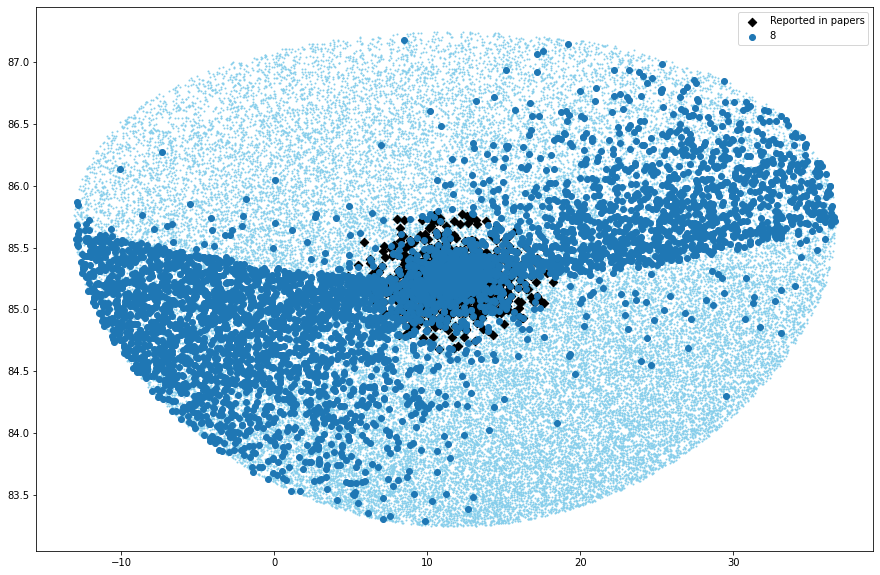

In [1028]:
plt.figure(figsize=(15, 10))
plt.scatter(sources.ra, sources.dec, s=1, color='skyblue')
plt.scatter(from_lit_edr3.ra, from_lit_edr3.dec, color='black', zorder=1,
                marker='D', label='Reported in papers')
for ul in [8]:
    plt.scatter(sources[sources['labels']==ul].ra, sources[sources['labels']==ul].dec, label=ul)
plt.legend()

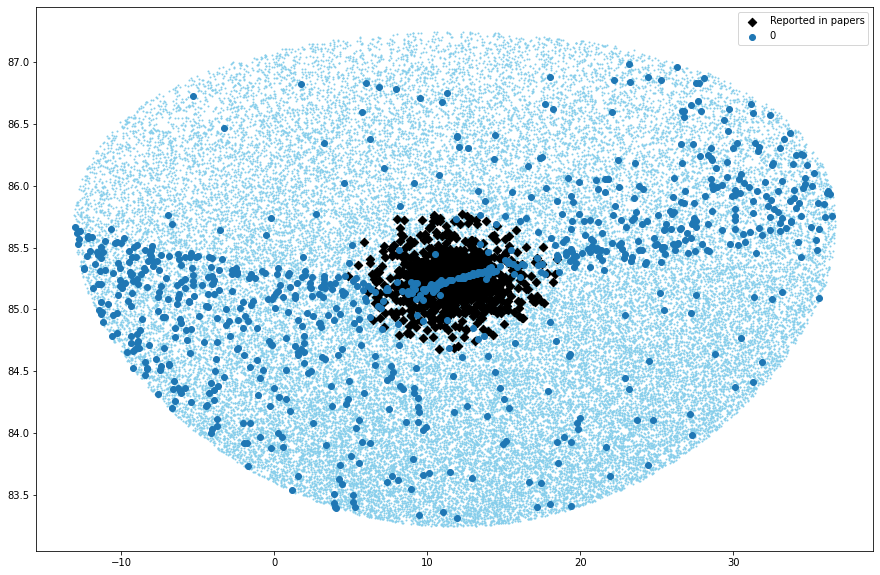

In [1067]:
plt.figure(figsize=(15, 10))
plt.scatter(sources.ra, sources.dec, s=1, color='skyblue')
plt.scatter(from_lit_edr3.ra, from_lit_edr3.dec, color='black', zorder=1,
                marker='D', label='Reported in papers')
proper_motion_mask = (np.abs(cluster_values.u_par)<.25) & (np.abs(cluster_values.u_per)<.25)
plt.scatter(sources[proper_motion_mask].ra, sources[proper_motion_mask].dec, label=ul)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


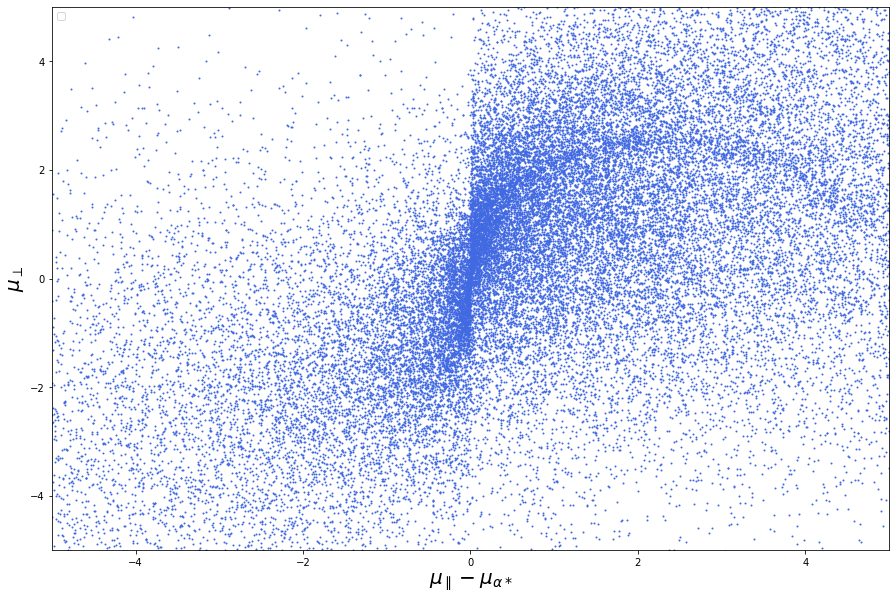

In [1073]:
plt.figure(figsize=(15, 10))
plt.scatter(cluster_values.u_par, cluster_values.u_per, s=1, color='royalblue')
# for ul in [0]:
#     plt.scatter(cluster_values[sources['labels']==ul].u_par, cluster_values[sources['labels']==ul].u_per, label=ul)
plt.legend()
plt.gca().set_xlim(-5, 5)
plt.gca().set_ylim(-5, 5)
plt.gca().set_ylabel('$\mu_\perp$', fontsize=20);
plt.gca().set_xlabel('$\mu_\parallel-\mu_{\\alpha*}$', fontsize=20);

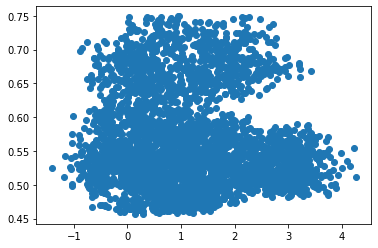

In [681]:
ul=0
plt.scatter(cluster_values[sources['labels']==ul].u_par, sources[sources['labels']==ul].parallax)

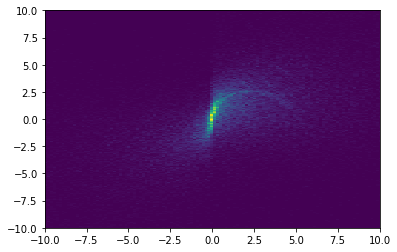

In [1000]:
plt.hist2d(cluster_values.u_par, cluster_values.u_per, bins=1000);
plt.gca().set_xlim(-10, 10)
plt.gca().set_ylim(-10, 10);

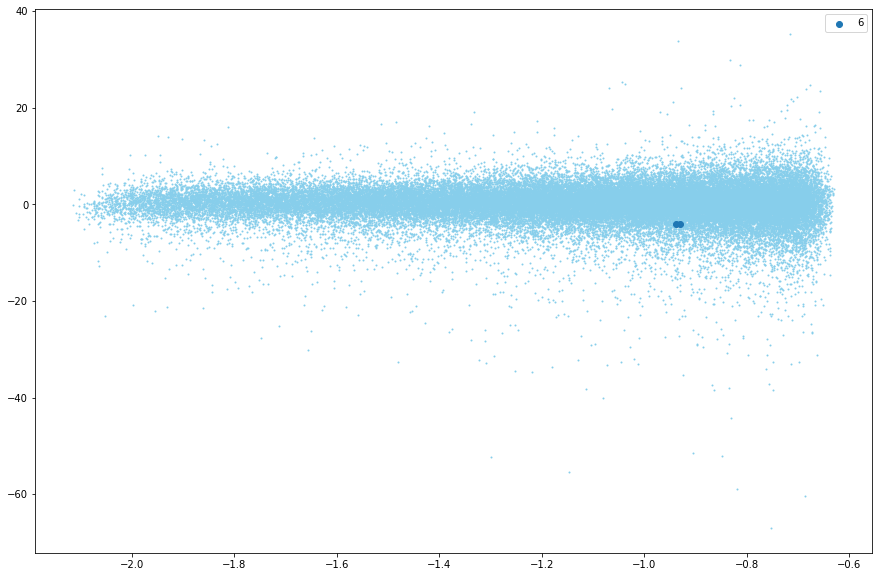

In [1001]:
plt.figure(figsize=(15, 10))
plt.scatter(cluster_values.x, cluster_values.u_per, s=1, color='skyblue')
for ul in [6]:
    plt.scatter(cluster_values[sources['labels']==ul].x, cluster_values[sources['labels']==ul].u_per, label=ul)
plt.legend()
# plt.gca().set_xlim(-20, 20)
# plt.gca().set_ylim(-10, 10)

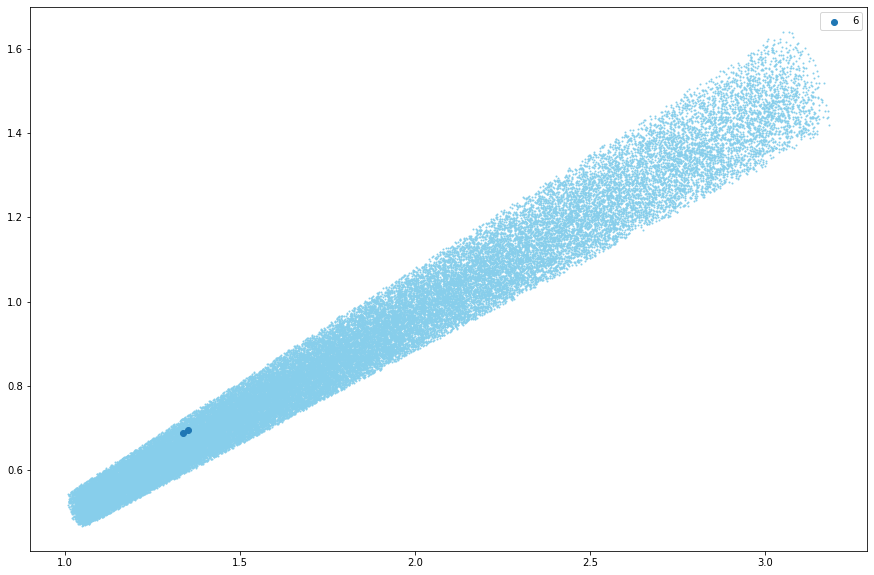

In [1002]:
plt.figure(figsize=(15, 10))
plt.scatter(cluster_values.y, cluster_values.z, s=1, color='skyblue')
for ul in [6]:
    plt.scatter(cluster_values[sources['labels']==ul].y, cluster_values[sources['labels']==ul].z, label=ul)
plt.legend()

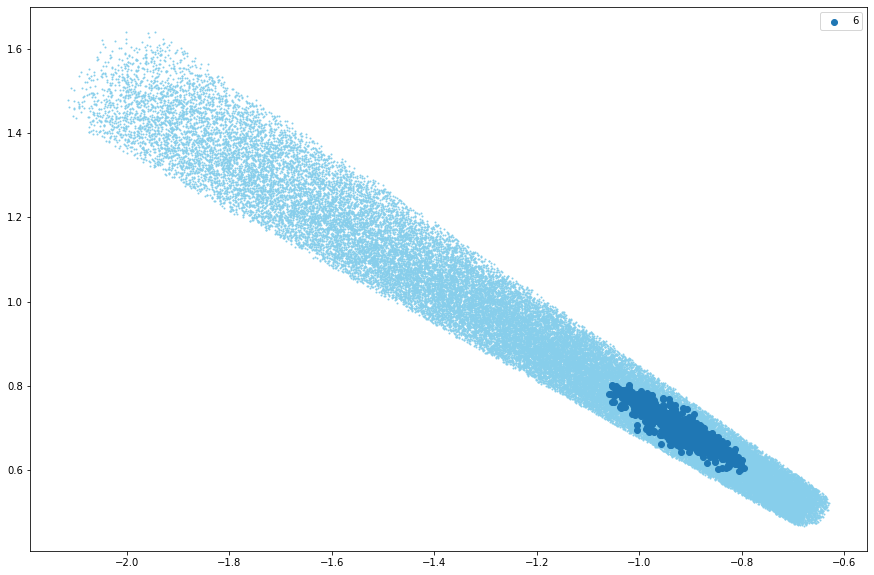

In [628]:
plt.figure(figsize=(15, 10))
plt.scatter(cluster_values.x, cluster_values.z, s=1, color='skyblue')
for ul in [6]:
    plt.scatter(cluster_values[sources['labels']==ul].x, cluster_values[sources['labels']==ul].z, label=ul)
plt.legend()

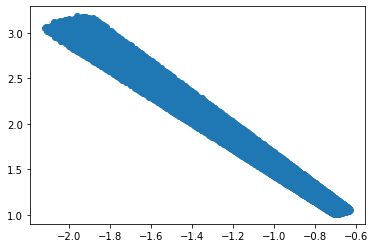

In [473]:
plt.scatter(cluster_values.x, cluster_values.y)

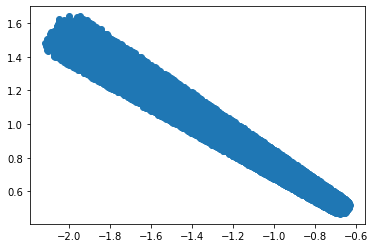

In [474]:
plt.scatter(cluster_values.x, cluster_values.z)

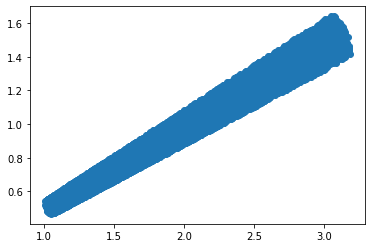

In [475]:
plt.scatter(cluster_values.y, cluster_values.z)

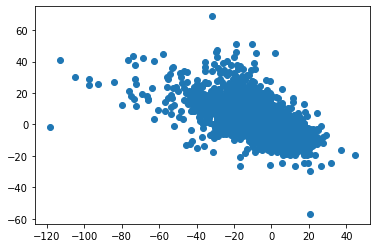

In [476]:
plt.scatter(cluster_values.u_par, cluster_values.u_per)